In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
n = str(1) #chiller number
df = pd.read_csv("data/Chiller"+n+"_full_ext.csv")
df.index = pd.to_datetime(df['ts'])
df.drop('ts', axis=1, inplace=True)
df.head()

,ch1Watt,ch2Watt,ch3Watt,value1,value2,value3,value4,conflowRate,conflowSpeed,evaflowRate,evaflowSpeed,value
ts,,,,,,,,,,,,
2017-05-30 22:47:00,353.0,0.0,346.0,23.761293,26.677246,28.161927,28.087160,0.0,0.0,0.0,0.0,25.925078
2017-05-30 22:48:00,354.0,0.0,350.0,23.761293,26.687927,28.108521,28.129882,0.0,0.0,0.0,0.0,25.917448
2017-05-30 22:49:00,353.0,0.0,350.0,23.825380,26.687927,28.129882,28.119202,0.0,0.0,0.0,0.0,25.925078
2017-05-30 22:50:00,352.0,0.0,348.0,23.846741,26.677246,28.151246,28.108521,0.0,0.0,0.0,0.0,25.955596
2017-05-30 22:51:00,356.0,0.0,350.0,23.761293,26.655885,28.204652,28.076477,0.0,0.0,0.0,0.0,25.940337


In [3]:
df['deltaT12'] = df['value2']-df['value1']
#df['deltaT34'] = df['value4']-df['value3']
df['totalWatt'] = df.apply(lambda row: row['ch1Watt']+row['ch2Watt']+row['ch3Watt'], axis=1)
df.drop(['ch1Watt', 'ch2Watt', 'ch3Watt'], inplace=True, axis=1)
df['H']=df['deltaT12']*df['evaflowRate']
df['COP']=df['H']/df['totalWatt']*4.19/3.6*1000

df=df[['value1','value3','value','conflowRate','evaflowRate','deltaT12','H','COP','totalWatt']] #reorder
df.columns=['value1','value3','value_ext','conflowRate','evaflowRate','deltaT12','H','COP','totalWatt'] #rename
df.head()

,value1,value3,value_ext,conflowRate,evaflowRate,deltaT12,H,COP,totalWatt
ts,,,,,,,,,
2017-05-30 22:47:00,23.761293,28.161927,25.925078,0.0,0.0,2.915953,0.0,0.0,699.0
2017-05-30 22:48:00,23.761293,28.108521,25.917448,0.0,0.0,2.926633,0.0,0.0,704.0
2017-05-30 22:49:00,23.825380,28.129882,25.925078,0.0,0.0,2.862547,0.0,0.0,703.0
2017-05-30 22:50:00,23.846741,28.151246,25.955596,0.0,0.0,2.830506,0.0,0.0,700.0
2017-05-30 22:51:00,23.761293,28.204652,25.940337,0.0,0.0,2.894592,0.0,0.0,706.0


In [4]:
df[(df['evaflowRate']>125)&(df['totalWatt']>25000)].drop(['COP'],axis=1).corr()

,value1,value3,value_ext,conflowRate,evaflowRate,deltaT12,H,totalWatt
value1,1.000000,0.498602,0.268622,0.070196,-0.111227,0.515118,0.508711,0.504886
value3,0.498602,1.000000,0.497253,0.431966,0.166644,0.843762,0.841743,0.864448
value_ext,0.268622,0.497253,1.000000,0.211188,-0.058688,0.488569,0.478993,0.533523
conflowRate,0.070196,0.431966,0.211188,1.000000,0.275351,0.365213,0.375209,0.396114
evaflowRate,-0.111227,0.166644,-0.058688,0.275351,1.000000,0.231069,0.272975,0.217307
deltaT12,0.515118,0.843762,0.488569,0.365213,0.231069,1.000000,0.998696,0.969778
H,0.508711,0.841743,0.478993,0.375209,0.272975,0.998696,1.000000,0.969436
totalWatt,0.504886,0.864448,0.533523,0.396114,0.217307,0.969778,0.969436,1.000000


In [5]:
X = df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1','value3','value_ext','conflowRate','evaflowRate','deltaT12','H']].as_matrix()
y = df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['totalWatt']].as_matrix().sum(axis=1)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [7]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(random_state=0,n_estimators=200)
regr.fit(X_train, y_train)

y_pred = regr.predict(X)
y_pred_test = regr.predict(X_test)

In [8]:
y_df = pd.DataFrame(np.concatenate((y.reshape((y.shape[0],1)), y_pred.reshape((y_pred.shape[0],1))), axis=1))
y_df.columns=['y_true', 'y_pred']
#y_df.plot(title='Randomized train and test set')

In [9]:
y_test_df = pd.DataFrame(np.concatenate((y_test.reshape((y_test.shape[0],1)), y_pred_test.reshape((y_pred_test.shape[0],1))), axis=1))
y_test_df.columns=['y_true', 'y_pred']
#y_test_df.plot(title='Test set')

In [10]:
from sklearn.metrics import mean_absolute_error as mae
print(mae(y_test, y_pred_test))
y_test_df['absolute error'] = abs(y_test_df['y_true'] - y_test_df['y_pred'])
y_test_df['relative error'] = abs(y_test_df['y_true'] - y_test_df['y_pred'])/y_test_df['y_true']
y_test_df.head()
y_test_df.describe()

3904.0906538


,y_true,y_pred,absolute error,relative error
count,3199.000000,3199.000000,3199.000000,3199.000000
mean,155500.640315,155148.126356,3904.090654,0.027266
std,47684.698040,47153.714238,6397.447384,0.054913
min,27182.000000,41694.140000,0.330000,0.000002
25%,126389.500000,126931.732500,531.257500,0.003543
50%,179087.000000,177087.995000,1574.680000,0.009895
75%,190936.000000,190357.039375,3955.832500,0.027193
max,225302.000000,223426.695000,105865.945000,1.604662


In [11]:
# value1, evaflowRate, deltaT12, H
print(regr.score(X_test,y_test))
regr.feature_importances_

0.975295421208


array([ 0.0219179 ,  0.01079077,  0.00861879,  0.00665572,  0.00937703,
        0.20437883,  0.73826097])

In [12]:
T3_min=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value3']].describe().loc['min'])[0]
T3_max=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value3']].describe().loc['max'])[0]
F_min=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['conflowRate']].describe().loc['min'])[0]
F_max=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['conflowRate']].describe().loc['max'])[0]

H=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['H']].describe().loc['mean'])[0]
T_ext=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value_ext']].describe().loc['mean'])[0]

In [13]:
T3=np.arange(np.floor(T3_min), np.ceil(T3_max), 0.5)
F=np.arange(np.floor(F_min), np.ceil(F_max), 0.5)
T1 = 23 # TO CHANGE ACCORDINGLY BY CHILLER AND H. Take best T1 results from Prediction-RandomForest
evaflowRate = 226.5 #227.5 # TO CHANGE ACCORDINGLY BY CHILLER AND H. Take best F results from Prediction-RandomForest
H = H # H gives average calculated above. CAN CHANGE TO 200, 800

In [14]:
#'value1','value3','value_ext','conflowRate','evaflowRate','deltaT12',H
def COP(T1,T3,T_ext,conflow,evaflow,H):
    n = len(T3)
    m = len(conflow)
    P_full=np.zeros((n,m))
    i=0
    for i in range(len(conflow)):
        F = conflow[i]
        X=np.array([T1*np.ones(n),T3,T_ext*np.ones(n),F*np.ones(n),
                    evaflow*np.ones(n),(H/evaflow)*np.ones(n),H*np.ones(n)]).T
        P = regr.predict(X)
        P_full[:,i]=P
    assert(P_full.shape == (n,m))
    return H/P_full*4.19/3.6*1000,P_full
COP_T,P_T = COP(T1,T3,T_ext,F,evaflowRate,H)

In [15]:
F_full=np.ones((len(T3),1)).dot(F.reshape(1,len(F)))
T3_full=np.ones((len(F),1)).dot(T3.reshape(1,len(T3))).T

<IPython.core.display.Javascript object>


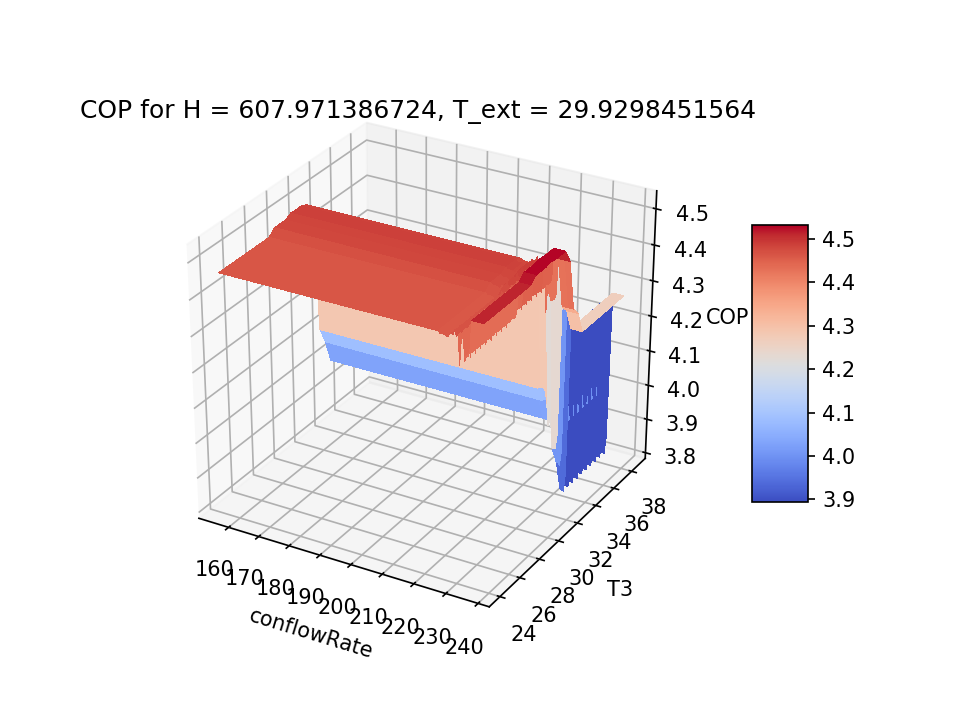

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(F_full, T3_full, COP_T,cmap=cm.coolwarm,linewidth=0, antialiased=False)
fig.colorbar(surf,shrink=0.5, aspect=5)
ax.set_xlabel('conflowRate')
ax.set_ylabel('T3')
ax.set_zlabel('COP')
ax.set_title('COP for H = '+str(H)+', T_ext = '+str(T_ext))

In [17]:
n=np.argmax(COP_T)
print("Best COP")
print(COP_T.reshape(-1)[n])
print("best F")
best_F=F_full.reshape(-1)[n]
print(best_F)
print("best T3")
print(T3_full.reshape(-1)[n])
best_F_index=np.where(F==best_F)

Best COP
4.533846959
best F
234.0
best T3
30.5


In [50]:
#optimized values from RandomForest step 2
H_list=[ 200,  250,  300,  350,  400,  450,  500,  550,  600,  650,  700,  750]
best_Fe_vary_H=[221.0, 225.5, 225.5, 225.5, 225.5, 227.5, 225.5, 232.5, 226.5, 226.5, 226.5, 226.5]
best_T1_vary_H=[7.0, 9.0, 9.0, 9.5, 9.5, 10.0, 10.0, 10.5, 10.0, 9.5, 9.0, 9.5]

T_min = df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value_ext']].describe().loc['25%'][0]
T_max = df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value_ext']].describe().loc['max'][0]
T_ext_list=np.arange(np.floor(T_min), np.ceil(T_max), 0.5)
n=len(H_list)
m=len(T_ext_list)
best_Fc_vary_Text = np.zeros((n,m))
best_T3_vary_Text = np.zeros((n,m))

In [51]:
T3=np.arange(np.floor(T3_min), np.ceil(T3_max), 0.5)
F=np.arange(np.floor(F_min), np.ceil(F_max), 0.5)
F_full=np.ones((len(T3),1)).dot(F.reshape(1,len(F)))
T3_full=np.ones((len(F),1)).dot(T3.reshape(1,len(T3))).T

for i in range(n): # vary heatload
    H=H_list[i]
    T1=best_T1_vary_H[i]
    evaflowRate=best_Fe_vary_H[i]
    print(str(i)+": Evaluating for H = "+str(H))
    
    for j in range(m): #vary t_ext
        T_ext=T_ext_list[j]
        COP_T,P_T = COP(T1,T3,T_ext,F,evaflowRate,H)
        n=np.argmax(COP_T)

        best_Fc_vary_Text[i,j]=(F_full.reshape(-1)[n])
        best_T3_vary_Text[i,j]=(T3_full.reshape(-1)[n])

0: Evaluating for H = 200
1: Evaluating for H = 250
2: Evaluating for H = 300
3: Evaluating for H = 350
4: Evaluating for H = 400
5: Evaluating for H = 450
6: Evaluating for H = 500
7: Evaluating for H = 550
8: Evaluating for H = 600
9: Evaluating for H = 650
10: Evaluating for H = 700
11: Evaluating for H = 750


In [52]:
H_list=np.array(H_list)
T_ext_list=np.array(T_ext_list)
H_full=np.ones((len(T_ext_list),1)).dot(H_list.reshape(1,len(H_list)))
Text_full=np.ones((len(H_list),1)).dot(T_ext_list.reshape(1,len(T_ext_list))).T
print(H_full.shape)
print(Text_full.shape)
print(best_Fc_vary_Text.shape)

(18, 12)
(18, 12)
(12, 18)


<IPython.core.display.Javascript object>


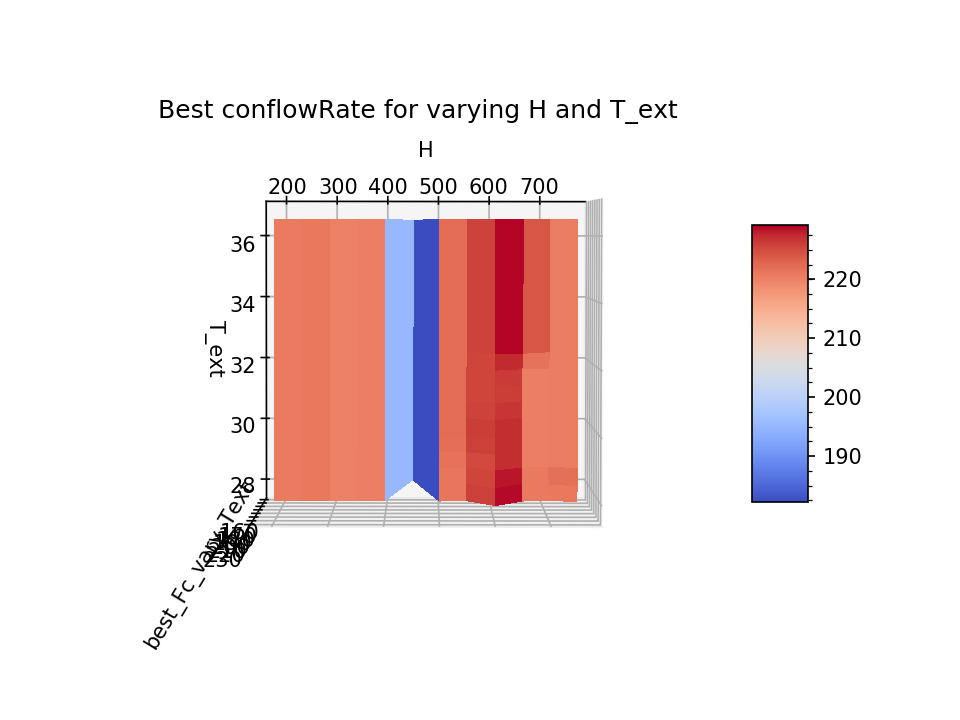

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(H_full, Text_full, best_Fc_vary_Text.T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
cb = fig.colorbar(surf,shrink=0.5, aspect=5)
cb.ax.minorticks_on()
ax.set_xlabel('H')
ax.set_ylabel('T_ext')
ax.set_zlabel('best_Fc_vary_Text')
ax.set_title("Best conflowRate for varying H and T_ext")

<IPython.core.display.Javascript object>


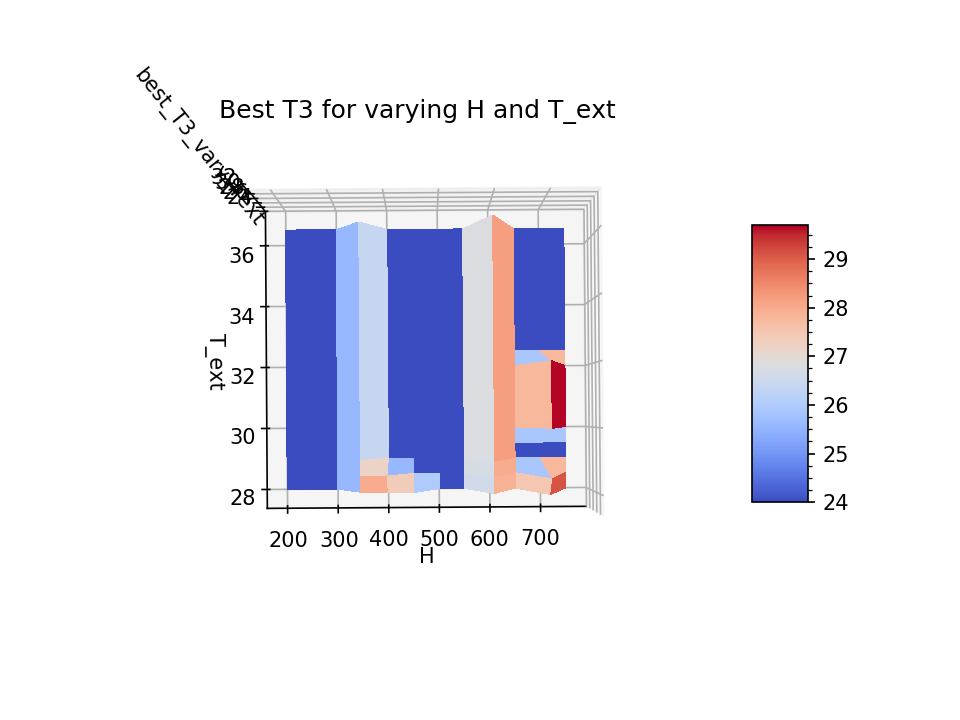

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(H_full, Text_full, best_T3_vary_Text.T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
cb = fig.colorbar(surf,shrink=0.5, aspect=5)
cb.ax.minorticks_on()
ax.set_xlabel('H')
ax.set_ylabel('T_ext')
ax.set_zlabel('best_T3_vary_Text')
ax.set_title("Best T3 for varying H and T_ext")